In [7]:
# -------------------- Model 1: SemiCorpus + CLIP --------------------
import pandas as pd
import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import time
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from IPython.display import display
import torch.nn.functional as F

# Set seed for reproducibility
random.seed(985)
np.random.seed(985)
torch.manual_seed(985)

# Load the datasets and image folder
m1_train = pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SemiCorpus_to_train.csv")
m1_val = pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SemiCorpus_to_validation.csv")
image_folder = "/Users/cyq/Desktop/Dissertation/Database/SemArt/images"

# Construct full path for each sample
m1_train["full_path"] = m1_train["IMAGE_FILE"].apply(lambda x: os.path.join(image_folder, x))
m1_val["full_path"] = m1_val["IMAGE_FILE"].apply(lambda x: os.path.join(image_folder, x))

# Define a dataset for Model 1
class SemArtDataset(Dataset):
    # Intialise the dataframe and CLIP precessor
    def __init__(self, df, processor): 
        self.data = df.reset_index(drop = True)
        self.processor = processor
        self.valid_idx = [i for i in range(len(self.data))
                          if os.path.exists(str(self.data.iloc[i]["full_path"]))]
    # Extract samples by rows
    def __getitem__(self, idx):
        ridx = self.valid_idx[idx]
        row = self.data.iloc[ridx] # Select the ith row from the dataframe
        path = row["full_path"] # Find the path
        text = str(row["DESCRIPTION"]) if not pd.isna(row["DESCRIPTION"]) else "" # Find the paired description
        # Try to open the image
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224, 224), "white")
            print(f"Warning: Failed to load {path}, using white image")
        # Preprocess both text and image
        inputs = self.processor(text = [text], 
                                images = img, 
                                return_tensors = "pt",
                                padding = "max_length", 
                                truncation = True, 
                                max_length = 77)
        # Return a dictionary contains input_ids, attention_mask and pixel_values
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0)
        }
    # Compute the length of dataset
    def __len__(self):
        return len(self.valid_idx)

# Define a function to evaluate model performance by using full-gallery retrieval
@torch.no_grad()
def evaluate_full_gallery(model, val_loader, device, topk = (1, 5, 10), chunk = 256):
    # Set the model to evaluation mode
    model.eval()
    # Create empty lists to contain all images and texts
    all_img = []
    all_txt = []
    # Loop through the validation dataloader to extract features
    for b in val_loader:
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract CLIP image and text features
        img = model.get_image_features(pix)
        txt = model.get_text_features(input_ids = ids, attention_mask = attn)
        # Normalize embeddings to unit length
        img = img / img.norm(p = 2, dim = -1, keepdim = True)
        txt = txt / txt.norm(p = 2, dim = -1, keepdim = True)
        # Add them into lists separatelt
        all_img.append(img)
        all_txt.append(txt)
    # Combine all batches into single tensors
    all_img = torch.cat(all_img, 0)
    all_txt = torch.cat(all_txt, 0)
    # Set N as the number of validation samples
    N = all_txt.size(0)
    # Get the learned logit scale
    logit_scale = model.logit_scale.exp().clamp_max(100.0)
    # Prepare to count Recall@K metrics
    max_k = max(topk)
    hits = {k:0 for k in topk} # Count of correct matches for each K
    ranks_list = [] # Create an empty list to contain the ground truth's rank position
    # Compute similarity
    for i in range(0, N, chunk):
        i_end = min(i + chunk, N)
        sims = logit_scale * (all_txt[i:i_end]@all_img.T) # Similarity matrix
        # Get the indices of top-k most similar images
        topk_idx = sims.topk(k = max_k, dim = 1).indices
        # Ground truth indices
        gt = torch.arange(i, i_end, device = sims.device)
        # Loop through to count Recall@K hits
        for k in topk:
            hits[k] += (topk_idx[:, :k] == gt.unsqueeze(1)).any(dim = 1).sum().item()
        # Compute the rank position of the ground truth image for each query
        gt_scores = sims.gather(1, gt.unsqueeze(1))
        ranks_list.append((sims >= gt_scores).sum(dim = 1).cpu())
    # Combine all rank positions
    ranks = torch.cat(ranks_list,0)
    # Calculate recall metrics
    rec = {f"R@{k}": hits[k] / float(N) for k in topk}
    rec["top1"] = rec["R@1"]
    rec["median_rank"] = ranks.median().item()
    rec["mean_rank"] = ranks.float().mean().item()
    return rec

# Define a function to evaluate model performance by using in-batch retrieval
@torch.no_grad()
def evaluate_in_batch(model, loader, device, topk = (1, 5, 10)):
    # Put the model in evaluation mode
    model.eval()
    # Initialize counters for the number of correct matches at each K value
    hits = {k: 0 for k in topk}
    # Total number of samples evaluated start from 0
    total = 0
    # Loop through each batch
    for b in loader:
        # Move text and image inputs to device
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract image and text embeddings and normalize embeddings to unit length
        img = F.normalize(model.get_image_features(pixel_values = pix), dim = -1)
        txt = F.normalize(model.get_text_features(input_ids = ids, attention_mask = attn), dim = -1)
        # Compute similarity matrix between texts and images within the same batch
        S = model.logit_scale.exp().clamp_max(100.0) * (txt @ img.T)
        # Get the maximum K value to optimize computation
        maxk_req = max(topk)
        maxk_eff = min(maxk_req, S.size(1))
        # Use topk to get indices of most similar images
        topk_idx = S.topk(k = maxk_eff, dim = 1).indices
        # Ground truth labels, each text should match the image at the same index
        labels = torch.arange(S.size(0), device = device)
        # Calculate the number of hits for each K value
        for k in topk:
            kk = min(k, S.size(1))
            hits[k] += (topk_idx[:, :kk] == labels.unsqueeze(1)).any(dim = 1).sum().item()
        # Update total number of evaluated samples
        total += S.size(0)
    return {f"Top@{k}": hits[k] / max(total, 1) for k in topk}

# Set processor, model and device
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast = False)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)
model.to(device) # Move model's parameters to the device
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters size: total = {total_params / 1e6:.2f}M, trainable = {trainable_params / 1e6:.2f}M")

# Set dataloader, optimizer and scheduler
m1_train_loader = DataLoader(SemArtDataset(m1_train, processor), 
                             batch_size = 16, 
                             shuffle = True,
                             num_workers = 0,
                             persistent_workers = False)
m1_val_loader = DataLoader(SemArtDataset(m1_val, processor), 
                           batch_size = 16,
                           shuffle = False,
                           num_workers = 0,
                           persistent_workers = False)
optimizer = AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.01)
scheduler = CosineAnnealingLR(optimizer, T_max = 20, eta_min = 5e-7)
run_start = time.time()
train_set_size = len(m1_train_loader.dataset)
val_set_size = len(m1_val_loader.dataset)
total_time = 0.0

# Define a directory to contain model
out_dir = "/Users/cyq/Desktop/Dissertation/Database/m1_clip_trained"
os.makedirs(out_dir, exist_ok = True) # Create the folder if it does not exist
cp_path = os.path.join(out_dir, "checkpoint.pt") # Define the checkpoint saving path
best_cp_path = os.path.join(out_dir, "best_checkpoint.pt") # Define the best checkpoint saving path
csv_path = os.path.join(out_dir, "epoch_metrics_m1.csv") # Define the csv file saving path

# Create empty lists to contain average losses and validation accuracy
avg_losses = []
val_accs = []

# Create empty lists for full-gallery evaluation
full_top1_list = []
full_top5_list = []
full_top10_list = []

# Create empty lists for in-batch evaluation
inb_top1_list = []
inb_top5_list = []
inb_top10_list = []

# Create an empty list to contain all metrics in each epoch
epoch_logs = []

# Prepare for the early stopping
patience = 2 # Number of consecutive epochs allowed without improvement
wait = 0 # Number of consecutive epochs without improvement
best_proxy = -1.0 # Highest recorded in-batch Top@1 accuracy
best_full = -1.0 # Highest recorded full-gallery R@1 accuracy
best_epoch = 0 # Epoch number when the best full-gallery R@1 was achieved
EVAL_EVERY = 4 # Run full-gallery evaluation every N epochs to reduce computational cost
min_delta = 1e-3 # Minimum improvement in the proxy metric required to reset the patience counter

# Set the starting epoch
start_epoch = 0

# If the code running was disrupted or stopped, resume training from last checkpoint
if os.path.exists(cp_path):
    # Load the saved checkpoint
    checkpoint = torch.load(cp_path, map_location = device)
    # Restore the model weights
    model.load_state_dict(checkpoint["model_state_dict"])
    # Restore the optimizer state
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    # If the scheduler exist in the checkpoint, restore the scheduler state
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    # Set the next starting epoch
    start_epoch = checkpoint["epoch"] + 1
    # Restore previously recorded metrics
    avg_losses = checkpoint.get("avg_losses", [])
    val_accs = checkpoint.get("val_accs", [])
    full_top1_list = checkpoint.get("full_top1_list", [])
    full_top5_list = checkpoint.get("full_top5_list", [])
    full_top10_list = checkpoint.get("full_top10_list", [])
    inb_top1_list = checkpoint.get("inb_top1_list", [])
    inb_top5_list = checkpoint.get("inb_top5_list", [])
    inb_top10_list = checkpoint.get("inb_top10_list", [])
    # Restore epoch with best performance
    best_epoch = checkpoint.get("best_epoch", 0)
    best_full = checkpoint.get("best_val_acc", -1)
    # Print the loading state
    print(f"Loaded checkpoint from epoch {start_epoch}")

# Loop through the epoch to train the model
for epoch in range(start_epoch, 20):
    # Set the model to the train mode
    model.train()
    # Print the current epoch number
    print(f"\n Epoch: {epoch + 1} / 20")
    epoch_t0 = time.time()
    full_eval_time = 0.0
    # Total loss start with 0
    total_loss = 0
    # Iterate over the training data in batches
    for step, batch in enumerate(tqdm(m1_train_loader)):
        # Move input data to device
        ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        pix = batch["pixel_values"].to(device)
        out = model(input_ids = ids, attention_mask = attn, pixel_values = pix, return_loss = True)
        loss = out.loss # Extract the loss value from the model output
        loss.backward()
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        # Update model weights
        optimizer.step()
        # Reset gradients to 0 before the next batch
        optimizer.zero_grad()
        # Accumulate the loss for calculating the average loss later
        total_loss += loss.item()
        # Print loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item():.4f}")
    # Calculate the average loss and add it to the list
    avg_loss = total_loss / len(m1_train_loader)
    avg_losses.append(avg_loss)
    # Validate the model by using in-batch retrieval
    inb = evaluate_in_batch(model, m1_val_loader, device, topk = (1, 5, 10))
    proxy = inb["Top@1"] # Use as the early stopping proxy metric
    # Add in-batch recall scores into lists separately
    inb_top1_list.append(inb["Top@1"])
    inb_top5_list.append(inb["Top@5"])
    inb_top10_list.append(inb["Top@10"])
    # Check if the improvement exceeds minimum delta
    improved_proxy = proxy > best_proxy + min_delta
    # Decide whether to run a full-gallery evaluation
    do_full = improved_proxy or ((epoch % EVAL_EVERY) == 0) or ((epoch + 1) == 20)
    if do_full:
        # Run full-gallery evaluation
        t_full0 = time.time()
        rec = evaluate_full_gallery(model, m1_val_loader, device, 
                                    topk = (1, 5, 10), chunk = 128)
        full_eval_time = time.time() - t_full0
        # Add the recall scores into the list
        full_top1_list.append(rec["R@1"])
        full_top5_list.append(rec["R@5"])
        full_top10_list.append(rec["R@10"])
        # Use R@1 from full-gallery as the validation accuracy and add it into list
        val_acc = rec["R@1"]
        val_accs.append(val_acc)
        print(f"Full-gallery R@1: {rec['R@1']:.4f}, R@5: {rec['R@5']:.4f}, R@10: {rec['R@10']:.4f}")
        # Update the best full-gallery score and save checkpoint if it improved
        if val_acc > best_full + min_delta:
            best_full = val_acc
            best_epoch = epoch + 1
            # Save checkpoint with all the metrics
            torch.save({
                "epoch": epoch,
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "avg_losses": avg_losses,
                "val_accs": val_accs,
                "best_val_acc": best_full,
                "full_top1_list": full_top1_list, 
                "full_top5_list": full_top5_list, 
                "full_top10_list": full_top10_list,
                "inb_top1_list": inb_top1_list, 
                "inb_top5_list": inb_top5_list, 
                "inb_top10_list": inb_top10_list
            }, best_cp_path)
            print(f"Saved Best (full) checkpoint: epoch {epoch + 1}, full-gallery R@1 = {val_acc:.4f}")
    else:
        rec = {"R@1": np.nan, "R@5": np.nan, "R@10": np.nan, "median_rank": np.nan, "mean_rank": np.nan}
        full_eval_time = float('nan')
        print(f"Skip full-gallery this epoch. In-batch Top@1: {inb['Top@1']:.4f}, Top@5: {inb['Top@5']:.4f}, Top@10: {inb['Top@10']:.4f}")
    # Step the learning rate scheduler
    scheduler.step()
    # Get the current learning rate
    cur_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}: avg_loss = {avg_loss:.4f}; in-batch Top@1 = {proxy:.4f}, lr = {cur_lr:.2e}")
    epoch_time = time.time() - epoch_t0
    throughput = train_set_size / max(epoch_time, 1e-9)
    cur_ckpt_mb = os.path.getsize(cp_path) / 1e6 if os.path.exists(cp_path) else float('nan')
    best_ckpt_mb = os.path.getsize(best_cp_path) / 1e6 if os.path.exists(best_cp_path) else float('nan')
    # Record metrics for this epoch and save them to csv
    row = {
        "epoch": epoch + 1, 
        "avg_loss": avg_loss, 
        "lr": cur_lr,
        "inb_top1": inb["Top@1"], 
        "inb_top5": inb["Top@5"], 
        "inb_top10": inb["Top@10"],
        "full_R@1": rec["R@1"], 
        "full_R@5": rec["R@5"], 
        "full_R@10": rec["R@10"],
        "full_median_rank": rec["median_rank"], 
        "full_mean_rank": rec["mean_rank"],
        "did_full_gallery": do_full,
        "epoch_time_sec": epoch_time,
        "throughput_samples_per_sec": throughput,
        "full_eval_time_sec": full_eval_time,
        "trainable_params_M": trainable_params / 1e6,
        "total_params_M": total_params / 1e6,
        "ckpt_current_MB": cur_ckpt_mb,
        "ckpt_best_MB": best_ckpt_mb
    }
    epoch_logs.append(row)
    pd.DataFrame(epoch_logs).to_csv(csv_path, index = False)
    # Decide whether to do the early stopping
    if improved_proxy: # If the proxy improves, update it
        best_proxy = proxy
        wait = 0
    else: # If not, increase the wait counter
        wait += 1
        print(f"Early stop counter: {wait} / {patience}")
    if wait >= patience: # If the wait number bigger than patience, stop training early and print the best recorded scores
        print(f"Early stopping at epoch {epoch + 1}. Best full R@1 = {best_full:.4f}, best in-batch Top@1 = {best_proxy:.4f}")
        break
    # Save all the metrics for each epoch
    torch.save({
        "epoch": epoch, 
        "best_epoch": best_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "avg_losses": avg_losses, 
        "val_accs": val_accs,
        "best_val_acc": best_full,
        "full_top1_list": full_top1_list, 
        "full_top5_list": full_top5_list, 
        "full_top10_list": full_top10_list,
        "inb_top1_list": inb_top1_list, 
        "inb_top5_list": inb_top5_list, 
        "inb_top10_list": inb_top10_list
    }, cp_path)

total_time = time.time() - run_start
print(f"\nTotal training wall time: {total_time / 60:.1f} minutes.")

Using mps
Parameters size: total = 151.28M, trainable = 151.28M

 Epoch: 1 / 20


  0%|                                           | 1/978 [00:01<31:03,  1.91s/it]

Step 0: Loss = 0.6297


 10%|████▏                                    | 101/978 [02:11<18:40,  1.28s/it]

Step 100: Loss = 2.6728


 21%|████████▍                                | 201/978 [04:23<16:46,  1.29s/it]

Step 200: Loss = 2.3471


 31%|████████████▌                            | 301/978 [06:42<15:53,  1.41s/it]

Step 300: Loss = 2.0626


 41%|████████████████▊                        | 401/978 [08:59<12:48,  1.33s/it]

Step 400: Loss = 2.3777


 51%|█████████████████████                    | 501/978 [11:13<10:43,  1.35s/it]

Step 500: Loss = 2.4456


 61%|█████████████████████████▏               | 601/978 [13:26<08:17,  1.32s/it]

Step 600: Loss = 2.4357


 72%|█████████████████████████████▍           | 701/978 [15:39<06:16,  1.36s/it]

Step 700: Loss = 2.1280


 82%|█████████████████████████████████▌       | 801/978 [17:52<03:58,  1.35s/it]

Step 800: Loss = 2.1174


 92%|█████████████████████████████████████▊   | 901/978 [20:04<01:41,  1.32s/it]

Step 900: Loss = 1.7830


100%|█████████████████████████████████████████| 978/978 [21:47<00:00,  1.34s/it]


Full-gallery R@1: 0.0028, R@5: 0.0176, R@10: 0.0304
Saved Best (full) checkpoint: epoch 1, full-gallery R@1 = 0.0028
Epoch 1: avg_loss = 2.2525; in-batch Top@1 = 0.3326, lr = 4.97e-05

 Epoch: 2 / 20


  0%|                                           | 1/978 [00:01<31:23,  1.93s/it]

Step 0: Loss = 2.0262


 10%|████▏                                    | 101/978 [02:18<18:55,  1.30s/it]

Step 100: Loss = 1.3924


 21%|████████▍                                | 201/978 [04:25<17:36,  1.36s/it]

Step 200: Loss = 2.0113


 31%|████████████▌                            | 301/978 [06:45<14:35,  1.29s/it]

Step 300: Loss = 1.6742


 41%|████████████████▊                        | 401/978 [09:02<13:56,  1.45s/it]

Step 400: Loss = 1.7344


 51%|█████████████████████                    | 501/978 [11:17<10:49,  1.36s/it]

Step 500: Loss = 1.9156


 61%|█████████████████████████▏               | 601/978 [13:29<07:56,  1.26s/it]

Step 600: Loss = 1.5792


 72%|█████████████████████████████▍           | 701/978 [15:47<06:05,  1.32s/it]

Step 700: Loss = 1.2858


 82%|█████████████████████████████████▌       | 801/978 [17:57<04:03,  1.38s/it]

Step 800: Loss = 1.6545


 92%|█████████████████████████████████████▊   | 901/978 [20:05<01:40,  1.30s/it]

Step 900: Loss = 1.6764


100%|█████████████████████████████████████████| 978/978 [21:44<00:00,  1.33s/it]


Full-gallery R@1: 0.0066, R@5: 0.0281, R@10: 0.0506
Saved Best (full) checkpoint: epoch 2, full-gallery R@1 = 0.0066
Epoch 2: avg_loss = 1.6884; in-batch Top@1 = 0.3753, lr = 4.88e-05

 Epoch: 3 / 20


  0%|                                           | 1/978 [00:01<24:55,  1.53s/it]

Step 0: Loss = 1.3275


 10%|████▏                                    | 101/978 [02:14<19:40,  1.35s/it]

Step 100: Loss = 0.7649


 21%|████████▍                                | 201/978 [04:22<16:28,  1.27s/it]

Step 200: Loss = 1.0898


 31%|████████████▌                            | 301/978 [06:30<14:20,  1.27s/it]

Step 300: Loss = 1.0375


 41%|████████████████▊                        | 401/978 [08:38<12:44,  1.32s/it]

Step 400: Loss = 1.3307


 51%|█████████████████████                    | 501/978 [10:50<10:12,  1.28s/it]

Step 500: Loss = 1.4965


 61%|█████████████████████████▏               | 601/978 [12:57<08:00,  1.27s/it]

Step 600: Loss = 0.8928


 72%|█████████████████████████████▍           | 701/978 [15:05<05:55,  1.28s/it]

Step 700: Loss = 1.2501


 82%|█████████████████████████████████▌       | 801/978 [17:18<03:48,  1.29s/it]

Step 800: Loss = 1.3659


 92%|█████████████████████████████████████▊   | 901/978 [19:27<01:39,  1.29s/it]

Step 900: Loss = 0.9512


100%|█████████████████████████████████████████| 978/978 [21:06<00:00,  1.30s/it]


Full-gallery R@1: 0.0077, R@5: 0.0299, R@10: 0.0590
Saved Best (full) checkpoint: epoch 3, full-gallery R@1 = 0.0077
Epoch 3: avg_loss = 1.2050; in-batch Top@1 = 0.3985, lr = 4.73e-05

 Epoch: 4 / 20


  0%|                                           | 1/978 [00:01<26:13,  1.61s/it]

Step 0: Loss = 0.7757


 10%|████▏                                    | 101/978 [02:07<18:33,  1.27s/it]

Step 100: Loss = 0.5311


 21%|████████▍                                | 201/978 [04:17<16:32,  1.28s/it]

Step 200: Loss = 1.1596


 31%|████████████▌                            | 301/978 [06:23<14:08,  1.25s/it]

Step 300: Loss = 1.1271


 41%|████████████████▊                        | 401/978 [08:31<12:12,  1.27s/it]

Step 400: Loss = 1.0676


 51%|█████████████████████                    | 501/978 [10:38<09:57,  1.25s/it]

Step 500: Loss = 1.2274


 61%|█████████████████████████▏               | 601/978 [12:45<07:58,  1.27s/it]

Step 600: Loss = 0.6146


 72%|█████████████████████████████▍           | 701/978 [14:52<06:10,  1.34s/it]

Step 700: Loss = 0.7809


 82%|█████████████████████████████████▌       | 801/978 [16:59<03:45,  1.27s/it]

Step 800: Loss = 1.1768


 92%|█████████████████████████████████████▊   | 901/978 [19:06<01:39,  1.29s/it]

Step 900: Loss = 0.6055


100%|█████████████████████████████████████████| 978/978 [20:43<00:00,  1.27s/it]


Full-gallery R@1: 0.0128, R@5: 0.0394, R@10: 0.0688
Saved Best (full) checkpoint: epoch 4, full-gallery R@1 = 0.0128
Epoch 4: avg_loss = 0.8682; in-batch Top@1 = 0.4279, lr = 4.53e-05

 Epoch: 5 / 20


  0%|                                           | 1/978 [00:01<26:31,  1.63s/it]

Step 0: Loss = 0.3053


 10%|████▏                                    | 101/978 [02:08<19:54,  1.36s/it]

Step 100: Loss = 0.4359


 21%|████████▍                                | 201/978 [04:17<16:10,  1.25s/it]

Step 200: Loss = 0.7125


 31%|████████████▌                            | 301/978 [06:23<14:14,  1.26s/it]

Step 300: Loss = 0.3335


 41%|████████████████▊                        | 401/978 [08:29<12:04,  1.25s/it]

Step 400: Loss = 0.4191


 51%|█████████████████████                    | 501/978 [10:36<09:53,  1.24s/it]

Step 500: Loss = 0.5923


 61%|█████████████████████████▏               | 601/978 [12:41<07:54,  1.26s/it]

Step 600: Loss = 0.6970


 72%|█████████████████████████████▍           | 701/978 [14:48<05:44,  1.24s/it]

Step 700: Loss = 0.7287


 82%|█████████████████████████████████▌       | 801/978 [16:54<03:44,  1.27s/it]

Step 800: Loss = 0.8726


 92%|█████████████████████████████████████▊   | 901/978 [19:08<01:49,  1.42s/it]

Step 900: Loss = 0.5714


100%|█████████████████████████████████████████| 978/978 [20:46<00:00,  1.27s/it]


Full-gallery R@1: 0.0100, R@5: 0.0424, R@10: 0.0736
Epoch 5: avg_loss = 0.6272; in-batch Top@1 = 0.4384, lr = 4.28e-05

 Epoch: 6 / 20


  0%|                                           | 1/978 [00:01<25:25,  1.56s/it]

Step 0: Loss = 0.2804


 10%|████▏                                    | 101/978 [02:12<20:15,  1.39s/it]

Step 100: Loss = 0.3154


 21%|████████▍                                | 201/978 [04:32<16:42,  1.29s/it]

Step 200: Loss = 0.3104


 31%|████████████▌                            | 301/978 [06:45<14:46,  1.31s/it]

Step 300: Loss = 0.4144


 41%|████████████████▊                        | 401/978 [08:56<12:50,  1.34s/it]

Step 400: Loss = 0.3254


 51%|█████████████████████                    | 501/978 [11:09<10:17,  1.30s/it]

Step 500: Loss = 0.4749


 61%|█████████████████████████▏               | 601/978 [13:24<10:24,  1.66s/it]

Step 600: Loss = 0.4092


 72%|█████████████████████████████▍           | 701/978 [15:31<05:56,  1.29s/it]

Step 700: Loss = 1.4269


 82%|█████████████████████████████████▌       | 801/978 [17:41<03:41,  1.25s/it]

Step 800: Loss = 0.4306


 92%|█████████████████████████████████████▊   | 901/978 [19:55<01:45,  1.37s/it]

Step 900: Loss = 0.4065


100%|█████████████████████████████████████████| 978/978 [21:37<00:00,  1.33s/it]


Full-gallery R@1: 0.0128, R@5: 0.0437, R@10: 0.0744
Epoch 6: avg_loss = 0.4714; in-batch Top@1 = 0.4499, lr = 3.98e-05

 Epoch: 7 / 20


  0%|                                           | 1/978 [00:01<24:56,  1.53s/it]

Step 0: Loss = 0.2129


 10%|████▏                                    | 101/978 [02:18<22:46,  1.56s/it]

Step 100: Loss = 0.1718


 21%|████████▍                                | 201/978 [04:28<15:57,  1.23s/it]

Step 200: Loss = 0.3276


 31%|████████████▌                            | 301/978 [06:37<14:38,  1.30s/it]

Step 300: Loss = 0.3601


 41%|████████████████▊                        | 401/978 [08:52<13:01,  1.35s/it]

Step 400: Loss = 0.2302


 51%|█████████████████████                    | 501/978 [11:03<10:27,  1.32s/it]

Step 500: Loss = 0.5133


 61%|█████████████████████████▏               | 601/978 [13:17<08:03,  1.28s/it]

Step 600: Loss = 0.4642


 72%|█████████████████████████████▍           | 701/978 [15:26<05:57,  1.29s/it]

Step 700: Loss = 0.2413


 82%|█████████████████████████████████▌       | 801/978 [17:35<03:46,  1.28s/it]

Step 800: Loss = 0.0816


 92%|█████████████████████████████████████▊   | 901/978 [19:43<01:39,  1.30s/it]

Step 900: Loss = 0.2683


100%|█████████████████████████████████████████| 978/978 [21:21<00:00,  1.31s/it]


Full-gallery R@1: 0.0128, R@5: 0.0486, R@10: 0.0823
Epoch 7: avg_loss = 0.3658; in-batch Top@1 = 0.4571, lr = 3.65e-05

 Epoch: 8 / 20


  0%|                                           | 1/978 [00:01<24:58,  1.53s/it]

Step 0: Loss = 0.2283


 10%|████▏                                    | 101/978 [02:10<18:53,  1.29s/it]

Step 100: Loss = 0.1994


 21%|████████▍                                | 201/978 [04:17<16:25,  1.27s/it]

Step 200: Loss = 0.1891


 31%|████████████▌                            | 301/978 [06:24<14:40,  1.30s/it]

Step 300: Loss = 0.2784


 41%|████████████████▊                        | 401/978 [08:30<12:17,  1.28s/it]

Step 400: Loss = 0.2168


 51%|█████████████████████                    | 501/978 [10:36<10:08,  1.27s/it]

Step 500: Loss = 0.2128


 61%|█████████████████████████▏               | 601/978 [12:43<07:58,  1.27s/it]

Step 600: Loss = 0.2175


 72%|█████████████████████████████▍           | 701/978 [14:50<05:54,  1.28s/it]

Step 700: Loss = 0.2226


 82%|█████████████████████████████████▌       | 801/978 [16:58<03:48,  1.29s/it]

Step 800: Loss = 0.7023


 92%|█████████████████████████████████████▊   | 901/978 [19:06<01:38,  1.28s/it]

Step 900: Loss = 0.1702


100%|█████████████████████████████████████████| 978/978 [20:45<00:00,  1.27s/it]


Full-gallery R@1: 0.0158, R@5: 0.0504, R@10: 0.0882
Saved Best (full) checkpoint: epoch 8, full-gallery R@1 = 0.0158
Epoch 8: avg_loss = 0.2797; in-batch Top@1 = 0.4778, lr = 3.29e-05

 Epoch: 9 / 20


  0%|                                           | 1/978 [00:01<24:51,  1.53s/it]

Step 0: Loss = 0.1003


 10%|████▏                                    | 101/978 [02:14<19:31,  1.34s/it]

Step 100: Loss = 0.1084


 21%|████████▍                                | 201/978 [04:25<16:11,  1.25s/it]

Step 200: Loss = 0.0594


 31%|████████████▌                            | 301/978 [06:39<15:56,  1.41s/it]

Step 300: Loss = 0.1016


 41%|████████████████▊                        | 401/978 [08:50<12:18,  1.28s/it]

Step 400: Loss = 0.0145


 51%|█████████████████████                    | 501/978 [11:00<11:11,  1.41s/it]

Step 500: Loss = 0.4904


 61%|█████████████████████████▏               | 601/978 [13:10<07:49,  1.25s/it]

Step 600: Loss = 0.1706


 72%|█████████████████████████████▍           | 701/978 [20:23<08:35,  1.86s/it]

Step 700: Loss = 0.0854


 82%|█████████████████████████████████▌       | 801/978 [34:27<04:17,  1.45s/it]

Step 800: Loss = 0.2542


 92%|█████████████████████████████████████▊   | 901/978 [36:41<01:39,  1.29s/it]

Step 900: Loss = 0.2366


100%|█████████████████████████████████████████| 978/978 [38:28<00:00,  2.36s/it]


Full-gallery R@1: 0.0161, R@5: 0.0539, R@10: 0.0872
Epoch 9: avg_loss = 0.2228; in-batch Top@1 = 0.4642, lr = 2.91e-05
Early stop counter: 1 / 2

 Epoch: 10 / 20


  0%|                                           | 1/978 [00:01<25:57,  1.59s/it]

Step 0: Loss = 0.1977


 10%|████▏                                    | 101/978 [02:11<18:12,  1.25s/it]

Step 100: Loss = 0.0901


 21%|████████▍                                | 201/978 [04:22<16:33,  1.28s/it]

Step 200: Loss = 0.0489


 31%|████████████▌                            | 301/978 [06:53<14:52,  1.32s/it]

Step 300: Loss = 0.3487


 41%|████████████████▊                        | 401/978 [09:16<12:49,  1.33s/it]

Step 400: Loss = 0.0578


 51%|█████████████████████                    | 501/978 [11:41<15:05,  1.90s/it]

Step 500: Loss = 0.0854


 61%|█████████████████████████▏               | 601/978 [14:01<08:09,  1.30s/it]

Step 600: Loss = 0.0497


 72%|█████████████████████████████▍           | 701/978 [16:20<05:56,  1.29s/it]

Step 700: Loss = 0.0166


 82%|█████████████████████████████████▌       | 801/978 [18:43<04:05,  1.39s/it]

Step 800: Loss = 0.1066


 92%|█████████████████████████████████████▊   | 901/978 [20:58<01:45,  1.37s/it]

Step 900: Loss = 0.3059


100%|█████████████████████████████████████████| 978/978 [22:49<00:00,  1.40s/it]


Skip full-gallery this epoch. In-batch Top@1: 0.4594, Top@5: 0.8594, Top@10: 0.9663
Epoch 10: avg_loss = 0.1814; in-batch Top@1 = 0.4594, lr = 2.53e-05
Early stop counter: 2 / 2
Early stopping at epoch 10. Best full R@1 = 0.0158, best in-batch Top@1 = 0.4778

Total training wall time: 268.5 minutes.


,epoch,avg_loss,lr,inb_top1,inb_top5,inb_top10,full_R@1,full_R@5,full_R@10,full_median_rank,full_mean_rank,did_full_gallery,epoch_time_sec,throughput_samples_per_sec,full_eval_time_sec,trainable_params_M,total_params_M,ckpt_current_MB,ckpt_best_MB
0,1,2.252486,0.000050,0.332566,0.801380,0.956800,0.002812,0.017638,0.030419,372.0,647.014832,True,1543.602740,10.136675,89.019460,151.277313,151.277313,NaN,1815.815119
1,2,1.688445,0.000049,0.375256,0.820041,0.954755,0.006646,0.028119,0.050613,311.0,591.307251,True,1534.646318,10.195835,86.082385,151.277313,151.277313,1815.807129,1815.815183
2,3,1.204971,0.000047,0.398517,0.829243,0.964980,0.007669,0.029908,0.059049,261.0,550.463928,True,1496.766978,10.453865,86.656485,151.277313,151.277313,1815.807193,1815.815247
3,4,0.868176,0.000045,0.427914,0.859663,0.964980,0.012781,0.039366,0.068763,243.0,503.131378,True,1473.863994,10.616312,86.783250,151.277313,151.277313,1815.807257,1815.815311
4,5,0.627183,0.000043,0.438395,0.856339,0.966002,0.009969,0.042434,0.073620,223.0,504.819031,True,1475.772867,10.602580,88.173786,151.277313,151.277313,1815.807321,1815.815311
5,6,0.471362,0.000040,0.449898,0.861708,0.971626,0.012781,0.043712,0.074387,217.0,482.594330,True,1526.309511,10.251525,87.904013,151.277313,151.277313,1815.807385,1815.815311
6,7,0.365842,0.000036,0.457055,0.858129,0.966513,0.012781,0.048569,0.082311,213.0,487.489777,True,1507.366831,10.380353,86.209209,151.277313,151.277313,1815.807449,1815.815311
7,8,0.279747,0.000033,0.477761,0.861963,0.974693,0.015849,0.050358,0.088190,196.0,462.633942,True,1475.057977,10.607719,86.527785,151.277313,151.277313,1815.807577,1815.815631
8,9,0.222840,0.000029,0.464213,0.863241,0.972904,0.016104,0.053937,0.087168,205.0,478.408997,True,2535.343358,6.171551,86.067281,151.277313,151.277313,1815.807641,1815.815631
9,10,0.181358,0.000025,0.459356,0.859407,0.966258,NaN,NaN,NaN,NaN,NaN,False,1510.910580,10.356007,NaN,151.277313,151.277313,1815.807705,1815.815631


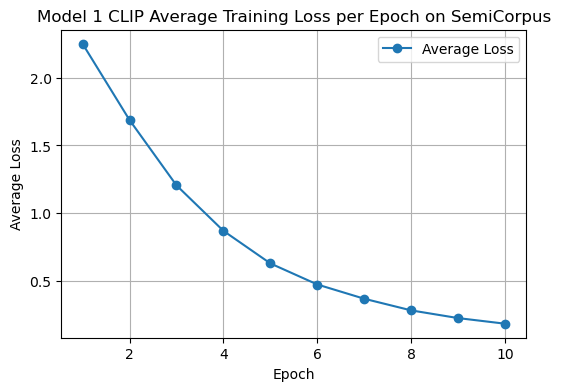

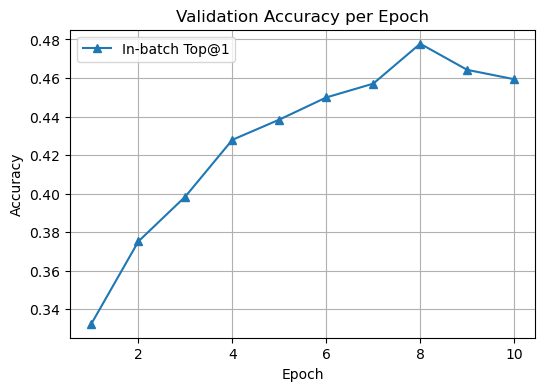


Best epoch: 8, Best full R@1: 0.0158


In [8]:
import pandas as pd

# Save results
epoch_m1 = pd.DataFrame(epoch_logs)
display(epoch_m1)
epoch_m1_path = os.path.join(out_dir, "m1_epoch_metrics.csv")
epoch_m1.to_csv(epoch_m1_path, index = False)

# Visualise the CLIP training average loss
plt.figure(figsize = (6, 4))
plt.plot(epoch_m1["epoch"],
         epoch_m1["avg_loss"],
         marker = "o",
         linestyle = "-",
         label = "Average Loss")
plt.title("Model 1 CLIP Average Training Loss per Epoch on SemiCorpus")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
loss_png = os.path.join(out_dir, "loss_curve_m1.png")
plt.savefig(loss_png, dpi = 200)
plt.show()
plt.close()

# Visualise the in-batch Top@1 curve
plt.figure(figsize = (6, 4))
plt.plot(epoch_m1["epoch"],
         epoch_m1["inb_top1"],
         marker = "^",
         linestyle = "-",
         label = "In-batch Top@1")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
acc_png = os.path.join(out_dir, "val_accuracy_m1.png")
plt.savefig(acc_png, dpi = 200)
plt.show()
plt.close()

# Save the final model
final_dir = os.path.join(out_dir, "final_model")
os.makedirs(final_dir, exist_ok = True)
model.save_pretrained(final_dir)
processor.save_pretrained(final_dir)
print(f"\nBest epoch: {best_epoch}, Best full R@1: {best_full:.4f}")